In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
# http://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost
import sys
import os

import pandas as pd
import numpy as np

# # Remote Data Access
# import pandas_datareader.data as web
# import datetime
# # reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#Read the data
#美国消费者信心指数
Sentiment = 'data/sentiment.csv'
Sentiment = pd.read_csv(Sentiment, index_col=0, parse_dates=[0])

In [38]:
Sentiment.head()

,UMCSENT
DATE,
2000-01-01,112.00000
2000-02-01,111.30000
2000-03-01,107.10000
2000-04-01,109.20000
2000-05-01,110.70000


In [39]:
# Select the series from 2005 - 2016
sentiment_short = Sentiment.loc['2005':'2016']

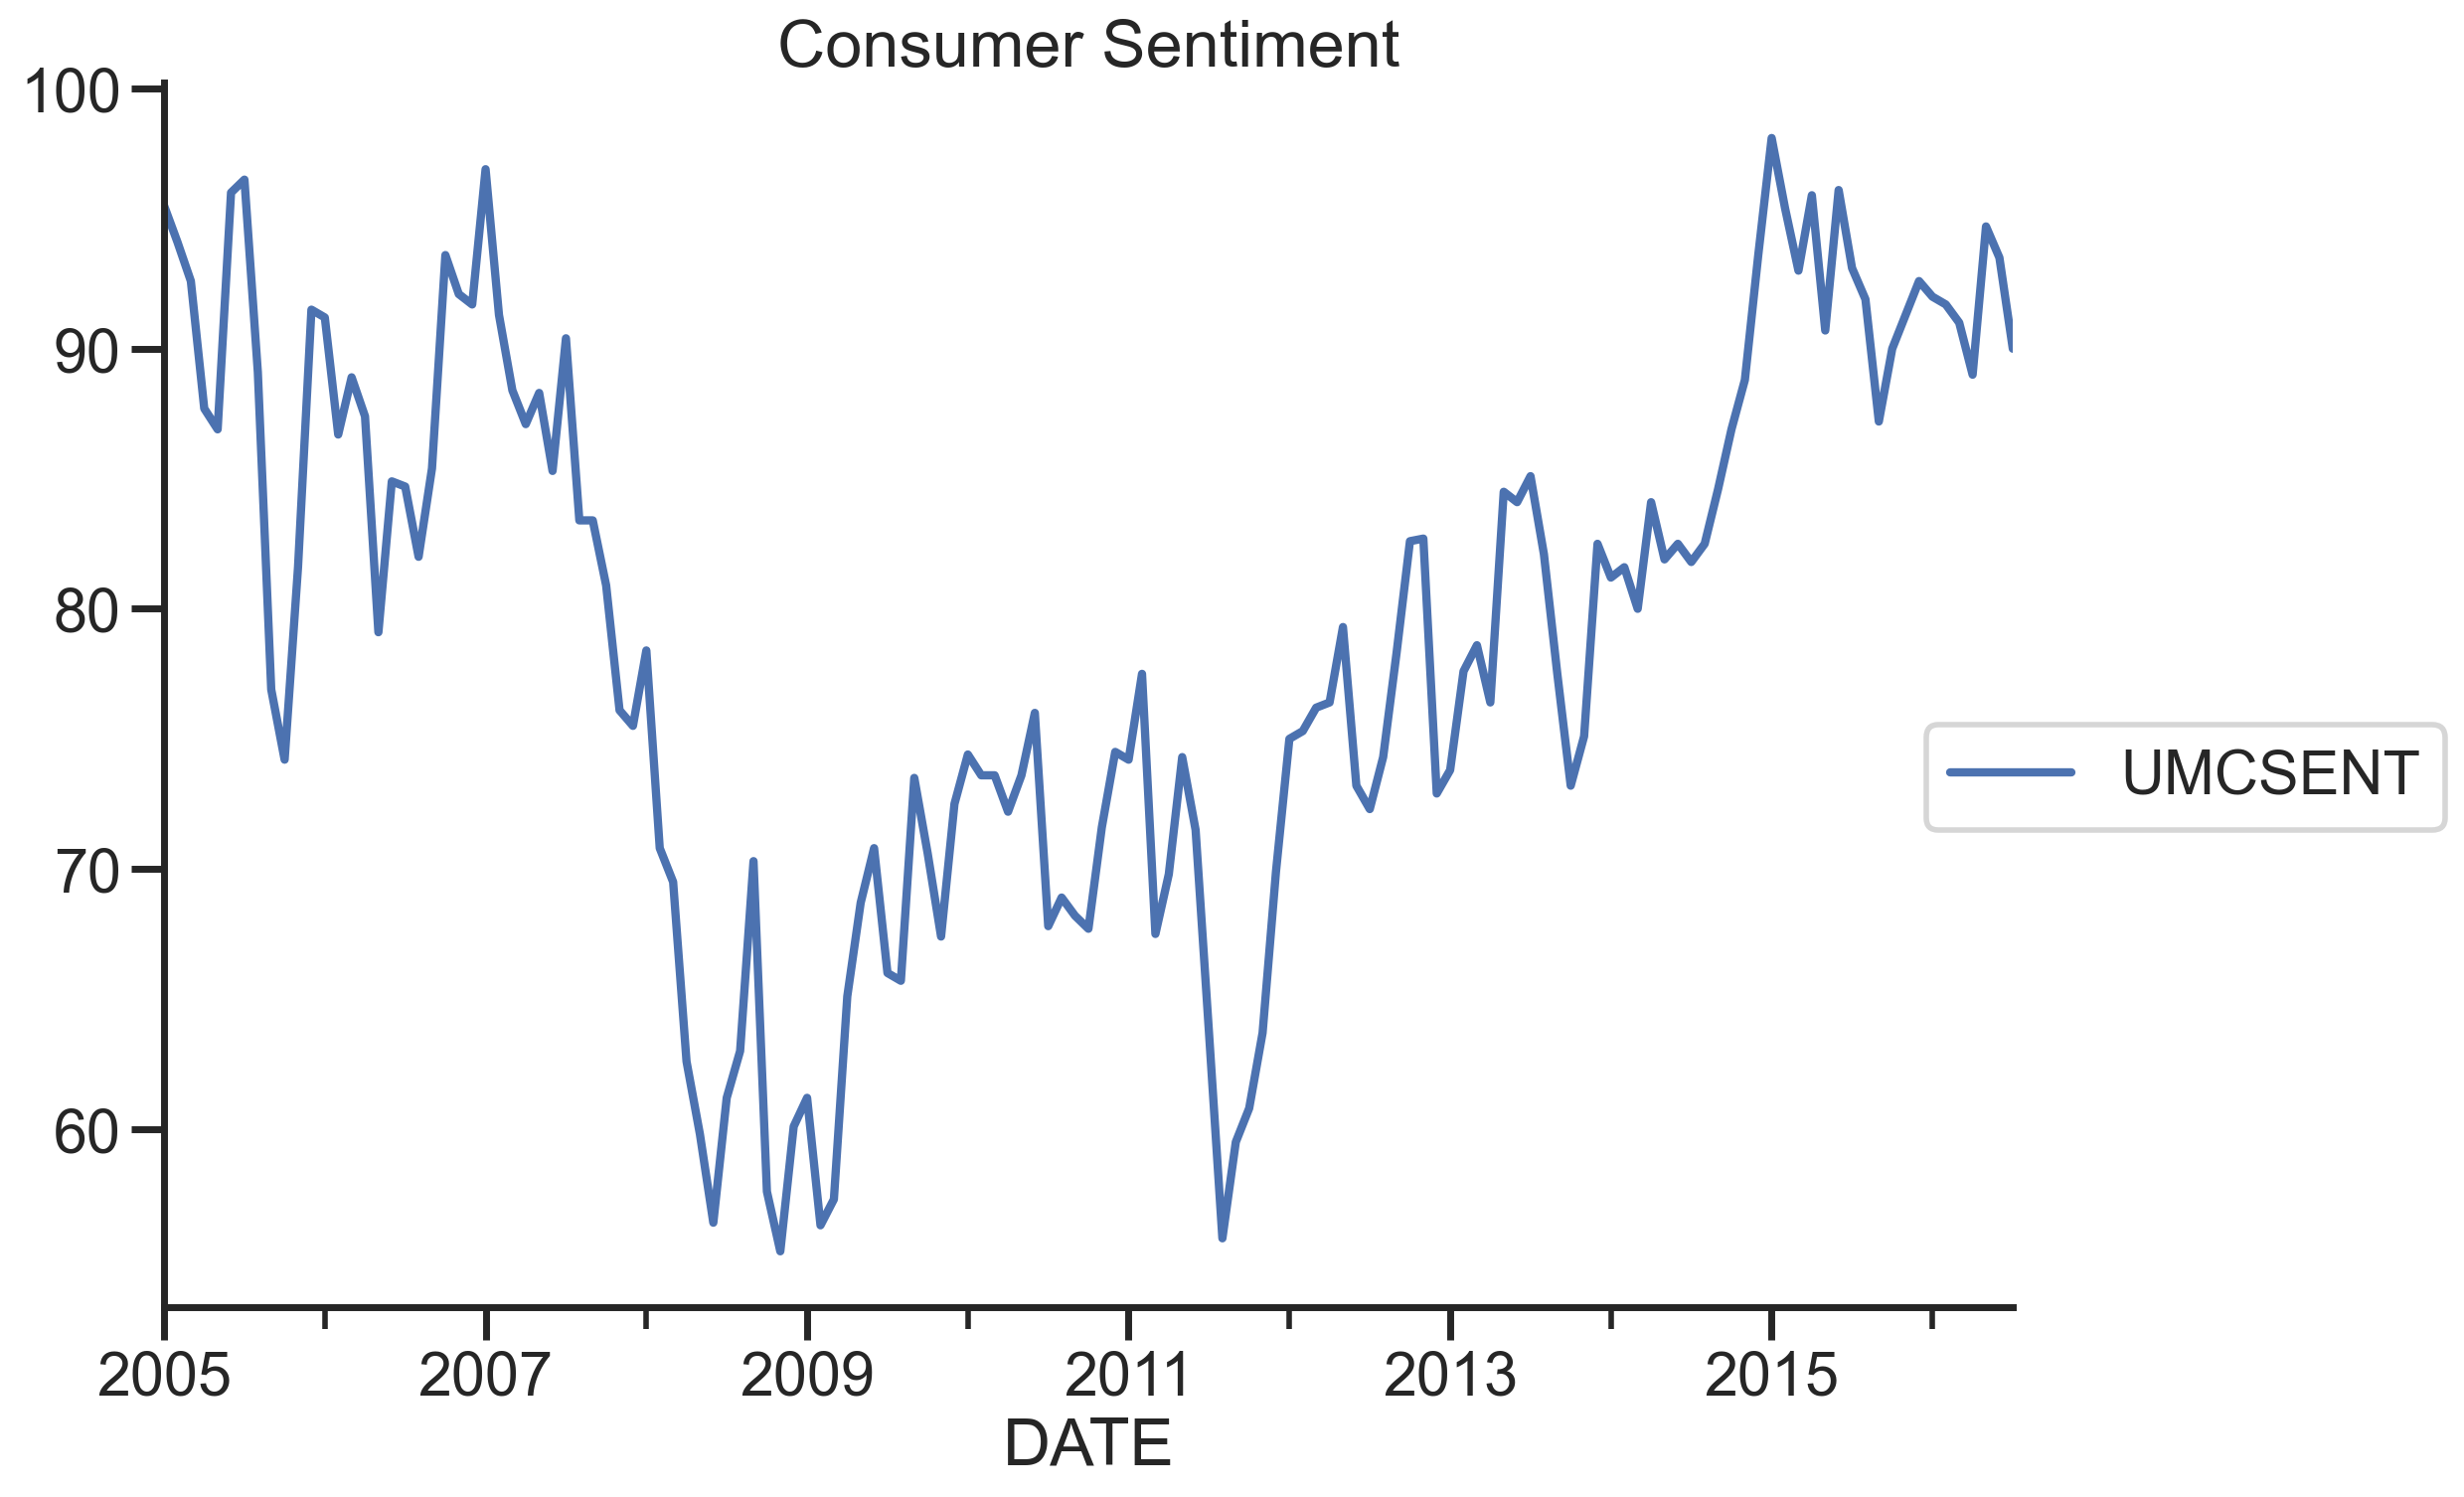

In [40]:
sentiment_short.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Consumer Sentiment")
sns.despine()

DATE
2005-01-01   95.50000
2005-02-01   94.10000
2005-03-01   92.60000
2005-04-01   87.70000
2005-05-01   86.90000
Name: UMCSENT, dtype: float64
DATE
2005-01-01        NaN
2005-02-01   -1.40000
2005-03-01   -1.50000
2005-04-01   -4.90000
2005-05-01   -0.80000
Name: diff_1, dtype: float64
DATE
2005-01-01        NaN
2005-02-01        NaN
2005-03-01   -0.10000
2005-04-01   -3.40000
2005-05-01    4.10000
Name: diff_2, dtype: float64


/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_54983/3960492216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1) # 当前的数据减去上面一个数据，（当上方无数据时则返回nan）
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_54983/3960492216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

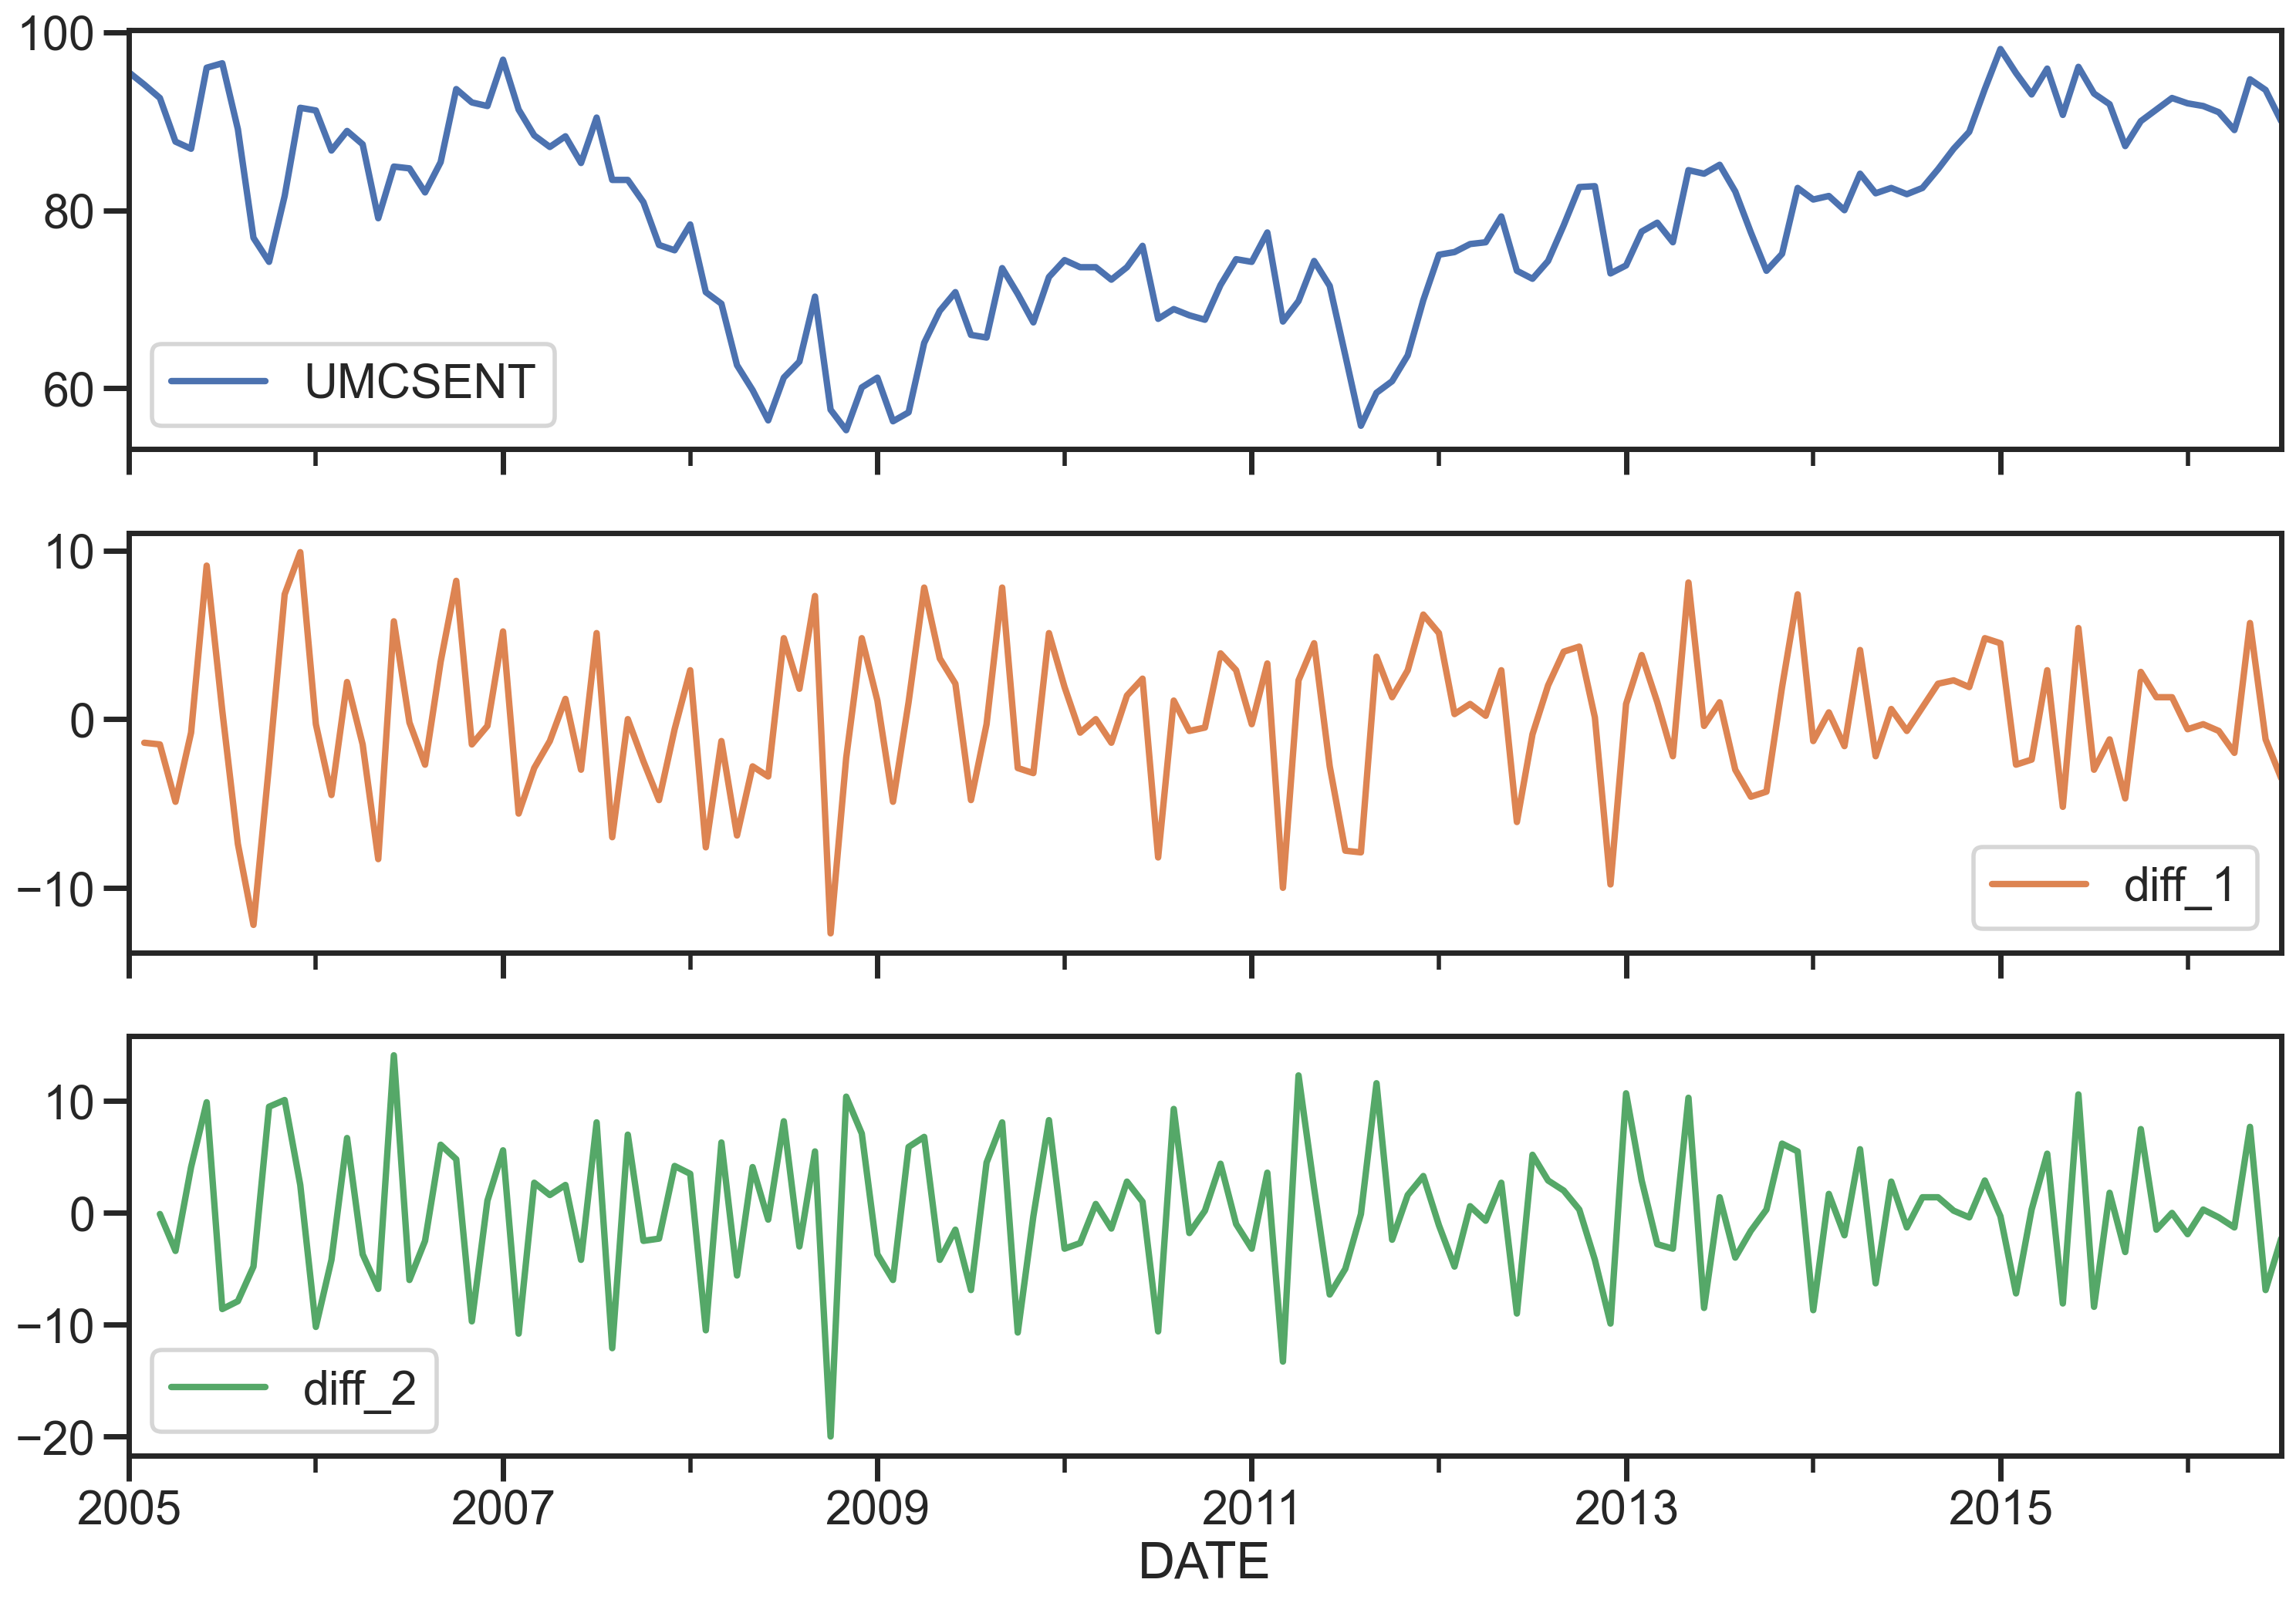

In [41]:
print(sentiment_short['UMCSENT'].head())
# 一阶差分
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1) # 当前的数据减去上面一个数据，（当上方无数据时则返回nan）
print(sentiment_short['diff_1'].head())
# 二阶差分
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
print(sentiment_short['diff_2'].head())
sentiment_short.plot(subplots=True, figsize=(18, 12))

In [42]:
del sentiment_short['diff_2']  # delete column
del sentiment_short['diff_1']
sentiment_short.head()
print (type(sentiment_short))

<class 'pandas.core.frame.DataFrame'>


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


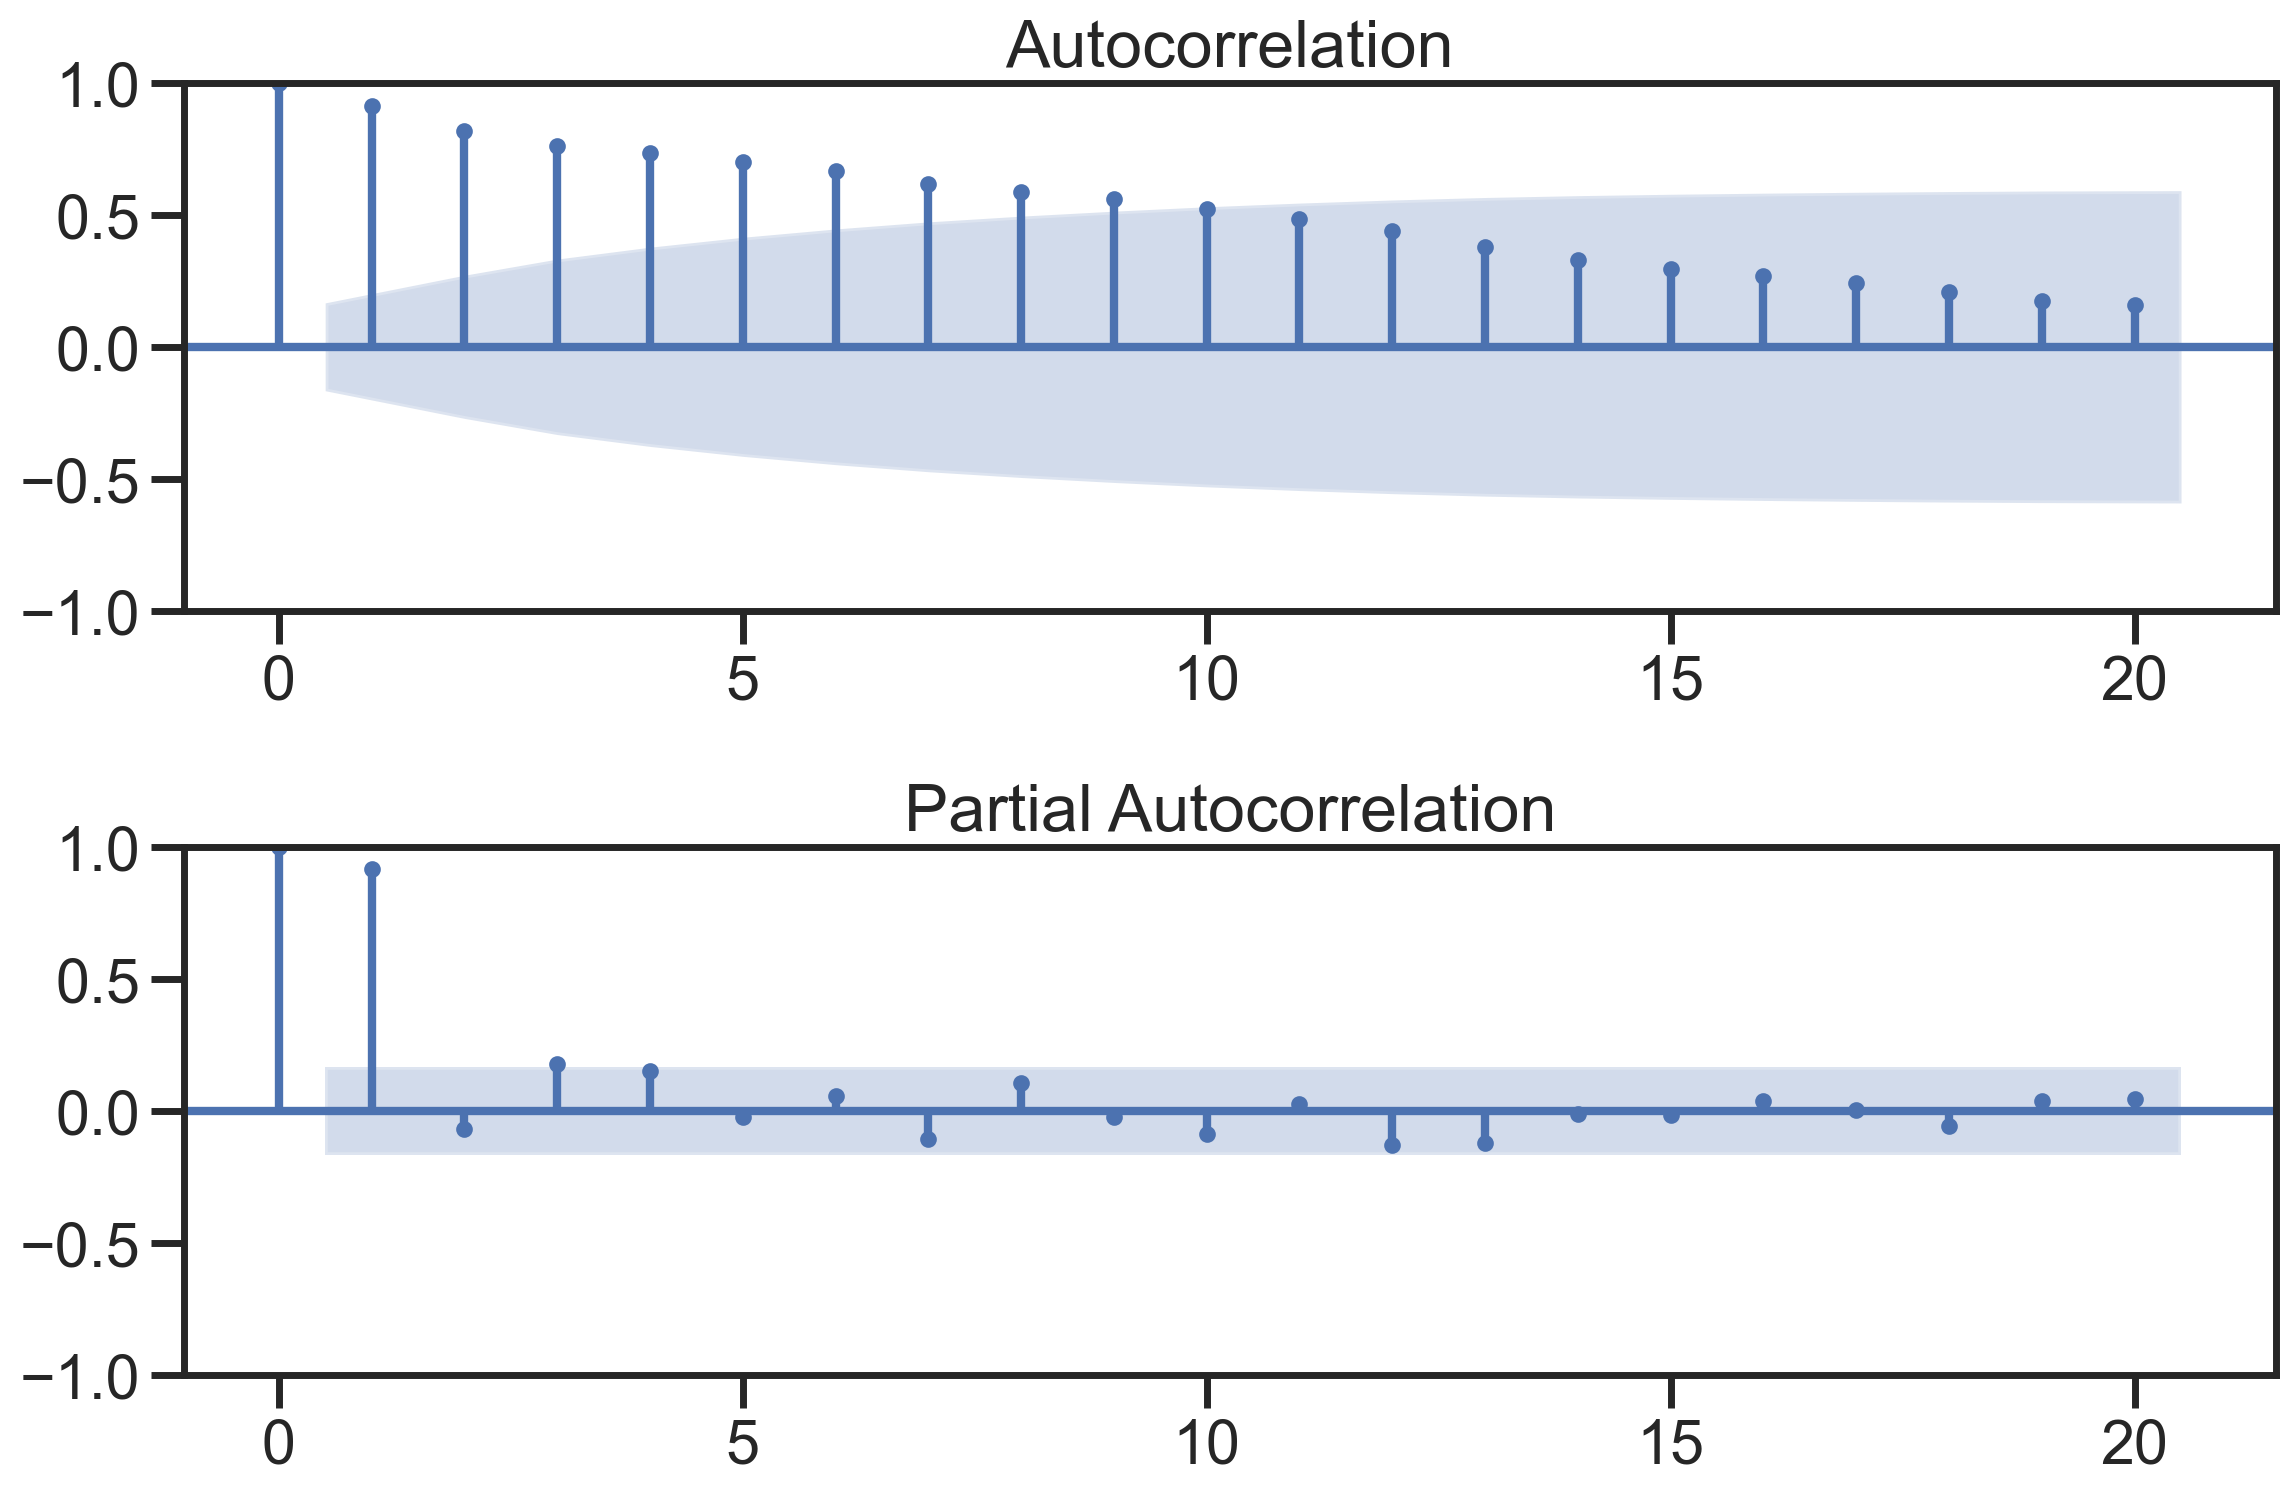

In [43]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

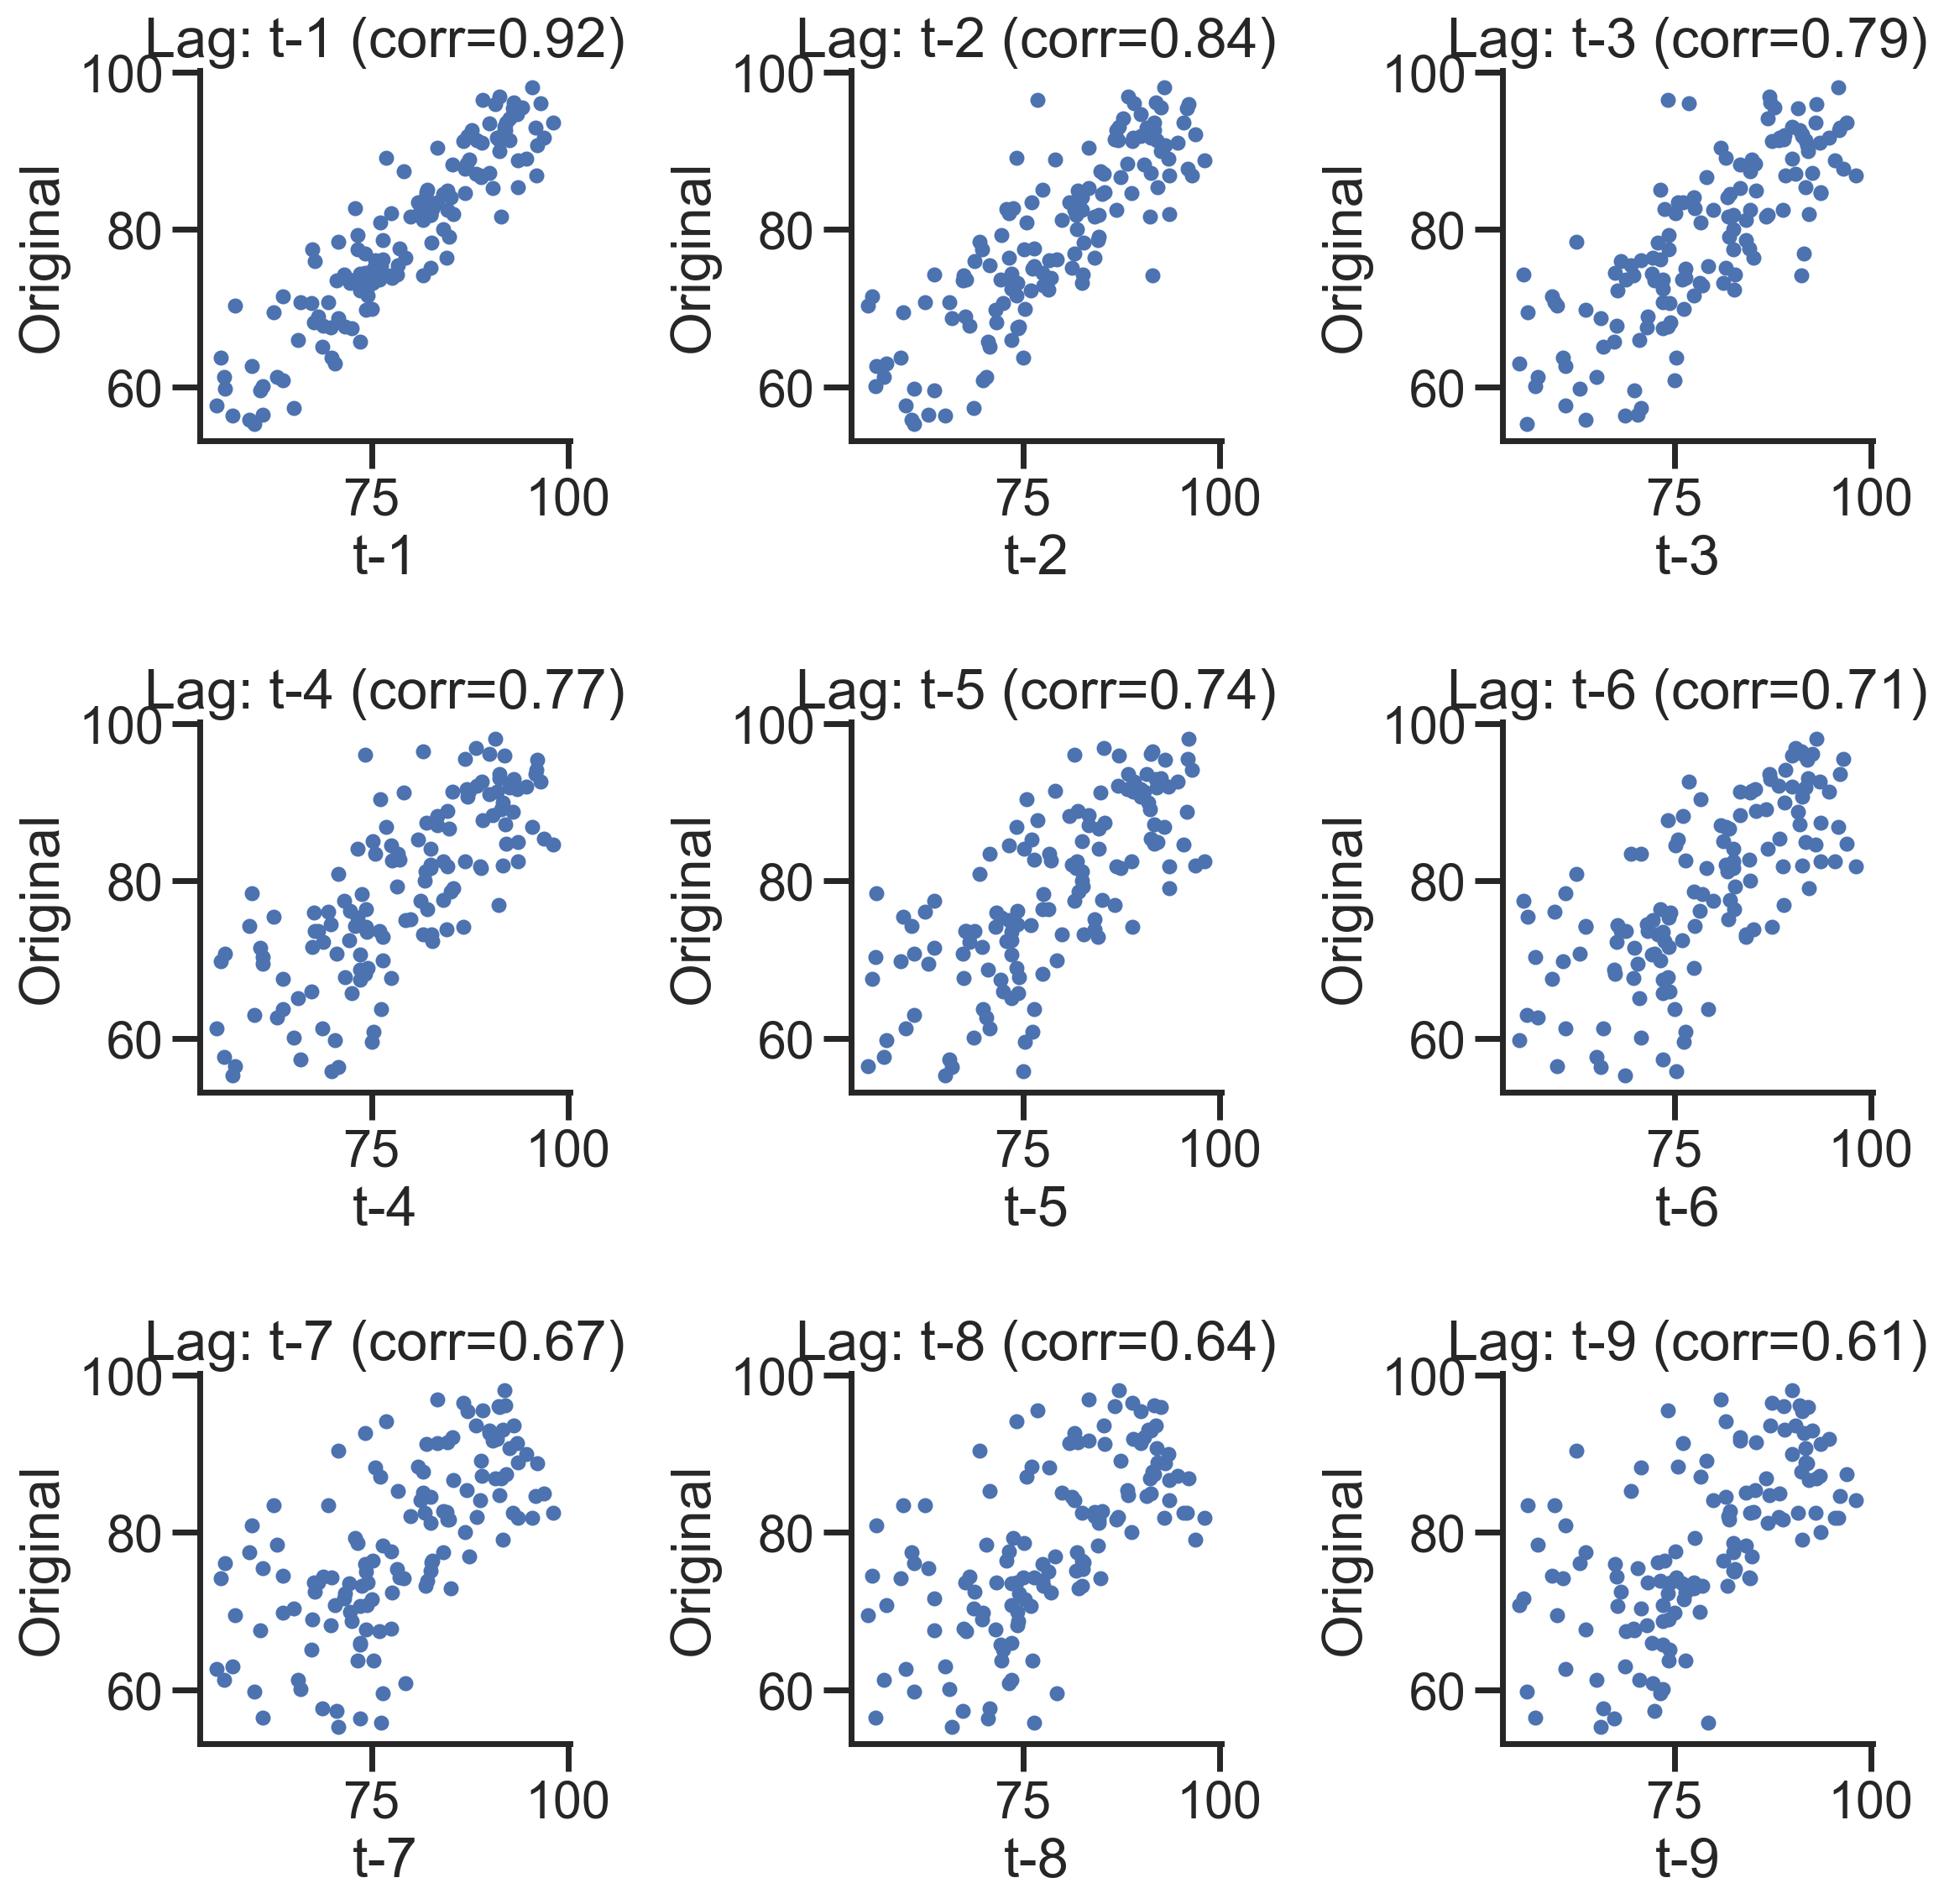

In [54]:
# 散点图也可以表示

lags=9

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([sentiment_short, sentiment_short.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str)
    corr = X.corr().values[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr))
    ax.set_aspect('equal')
    sns.despine()

fig.tight_layout()

In [49]:
# 更直观一些

def tsplot(y, lags=None, title='', figsize=(14, 8)):
   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


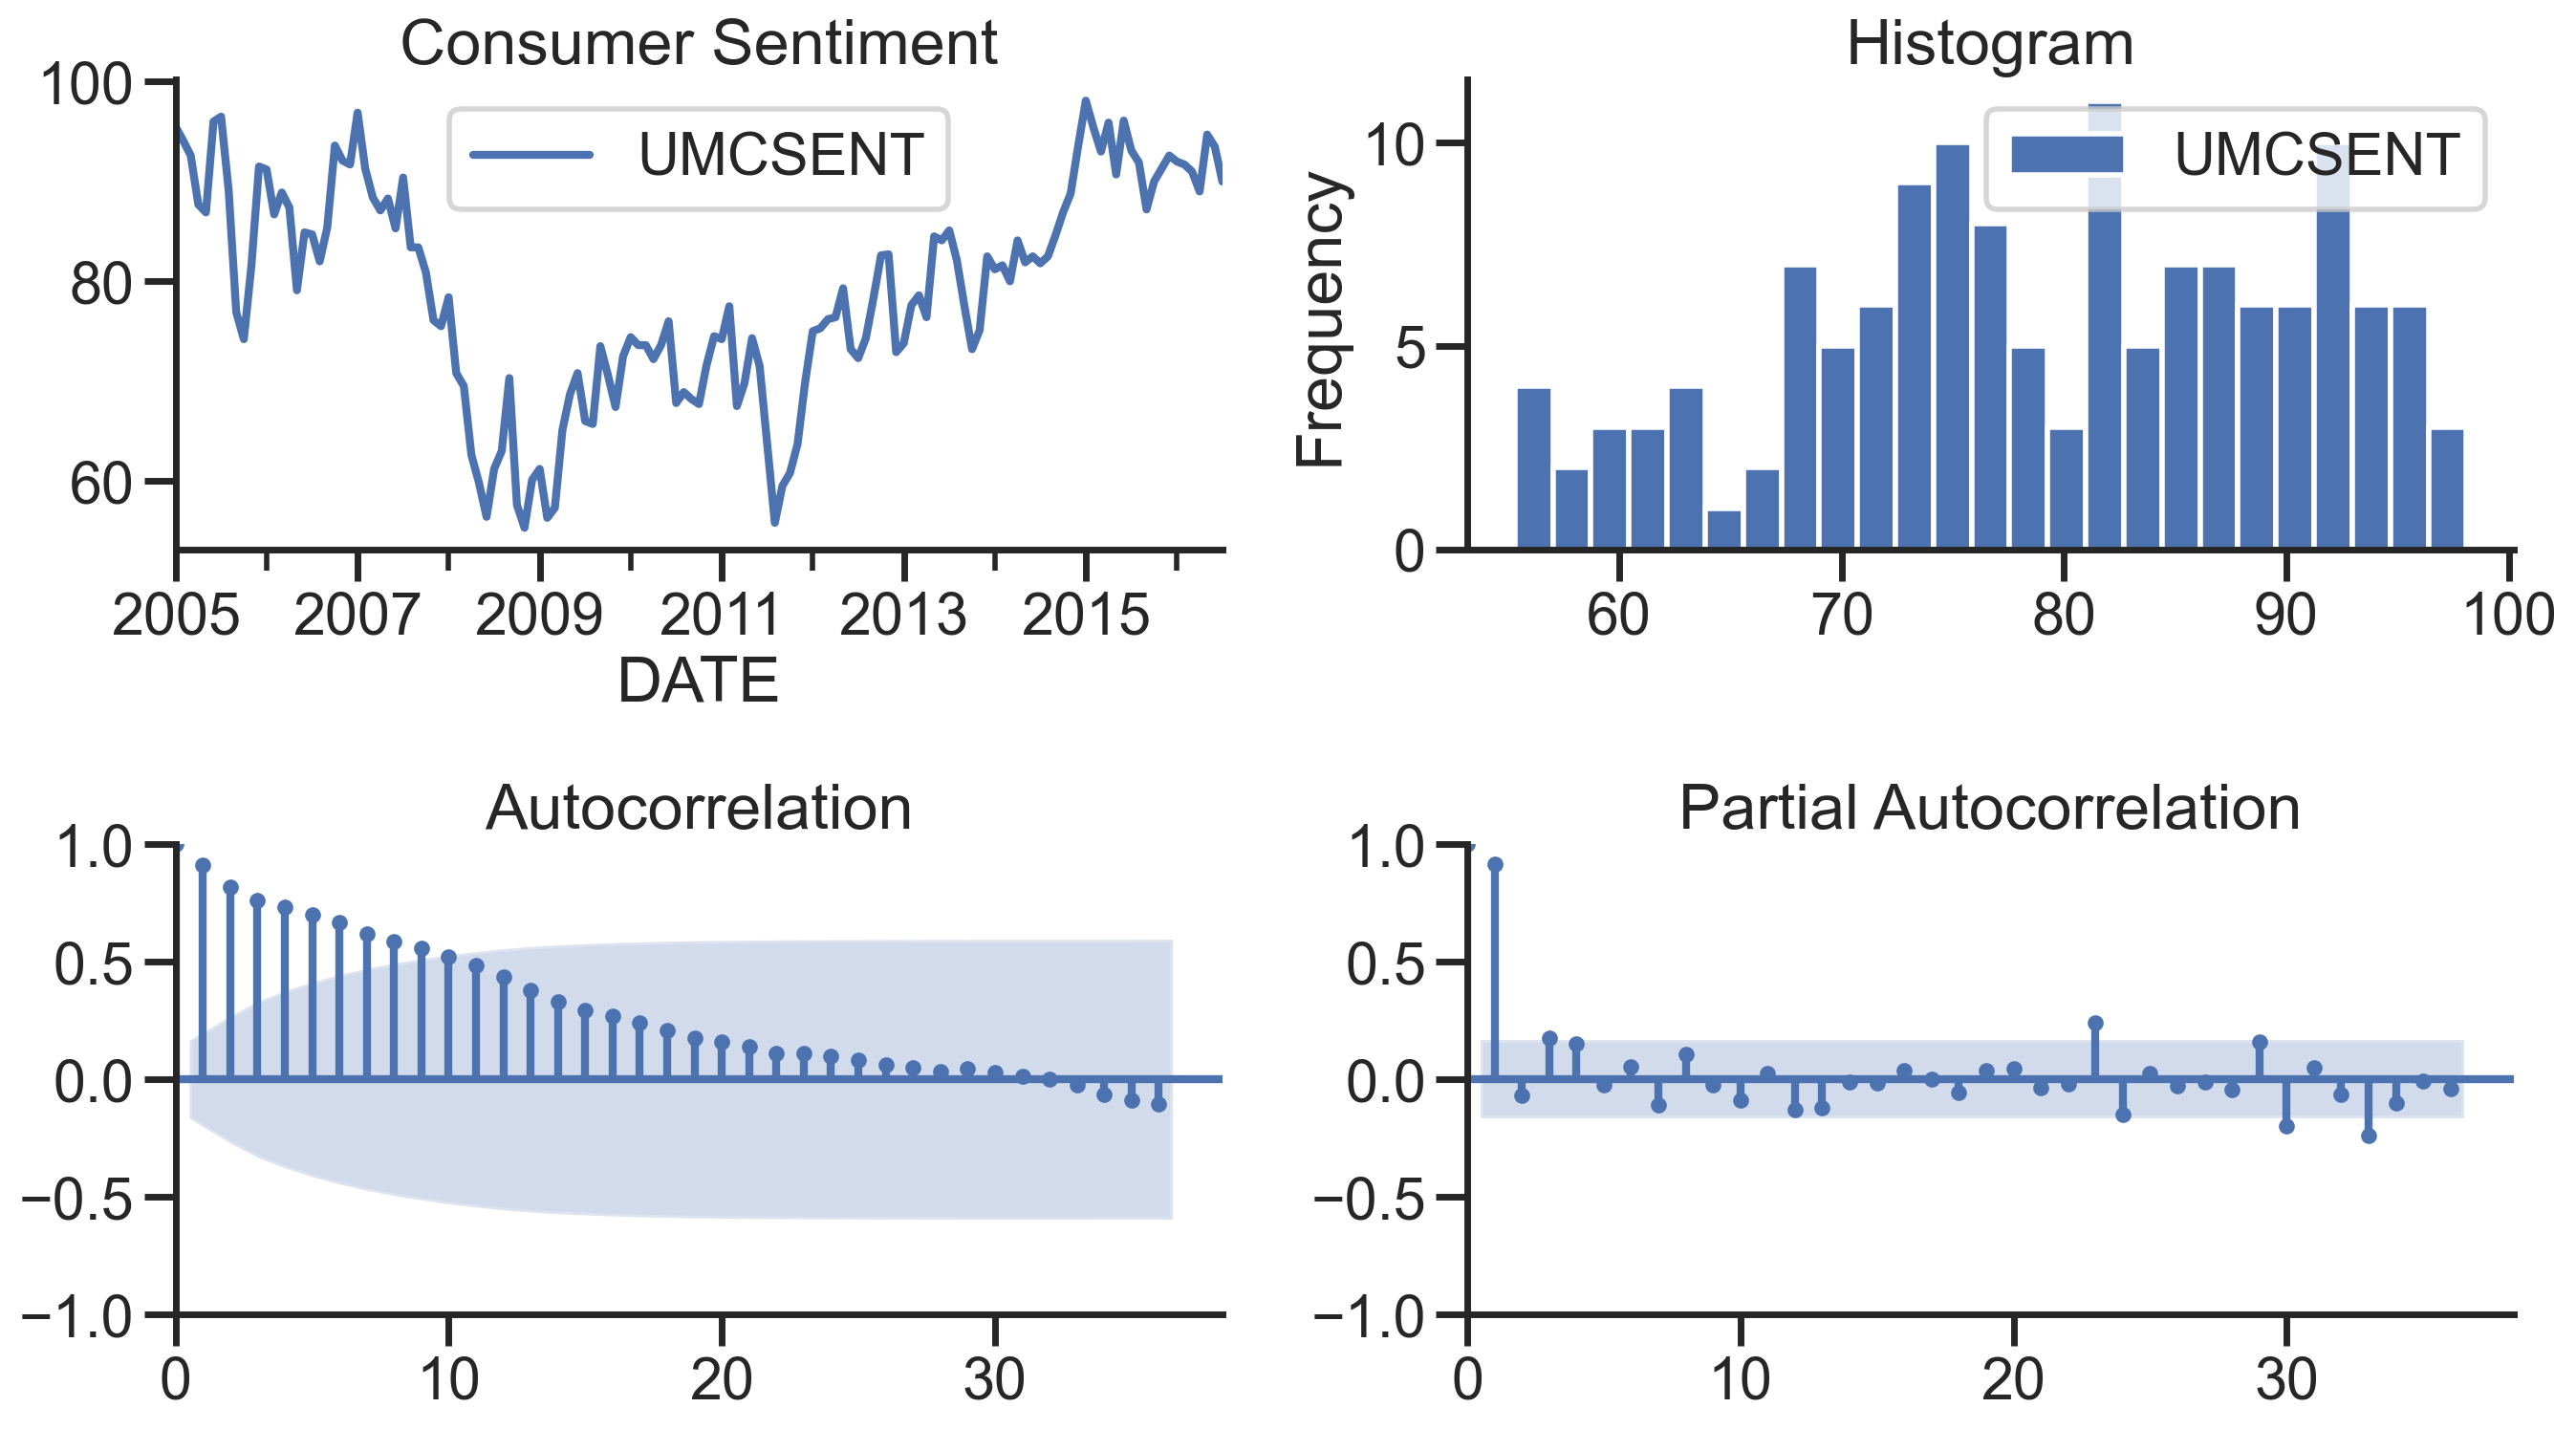

In [50]:
tsplot(sentiment_short, title='Consumer Sentiment', lags=36);